## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy import signal
from tqdm import tqdm
import os
import ffmpeg
import shutil

## Loading image

In [2]:
main_img = cv.imread('tasbih.jpg')

In [3]:
main_img.shape

(828, 1104, 3)

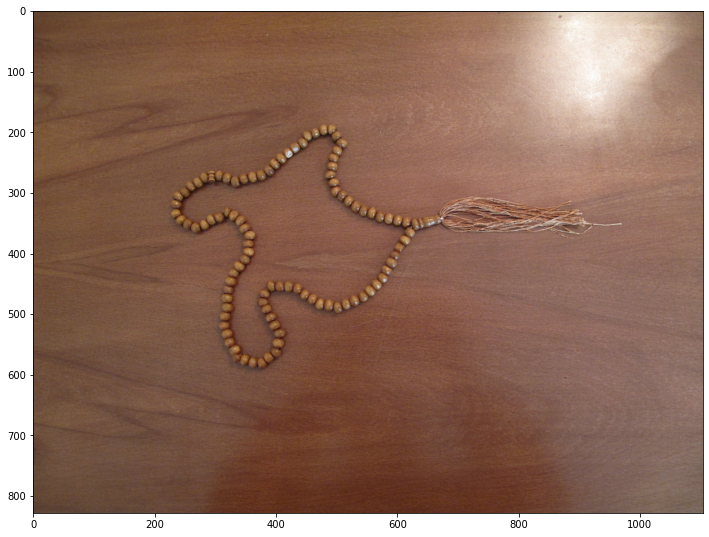

In [4]:
plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(main_img, cv.COLOR_BGR2RGB));

## Get surrounding area

You have to select the points of the desired polygon. For doing this, start from somewhere and continue clockwise. At the end **don't select the start point again**. Just press `esc` to finish selecting.

In [85]:
def get_points(source_img):
    color = (43, 57, 192)
    
    def draw_circle(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDBLCLK:
            cv.circle(img, (x, y), 6, color, -1)
            coords.append([y, x])
            if len(coords) > 1:
                cv.line(img, tuple(coords[-2])[::-1], tuple(coords[-1])[::-1], color, 4)
            cv.imshow('image', img)

    coords = []
    img = source_img.copy()
    
    cv.namedWindow('image')
    cv.setMouseCallback('image',draw_circle)
    cv.imshow('image', img)
    cv.waitKey(0)
    cv.destroyAllWindows()

    cv.line(img, tuple(coords[0])[::-1], tuple(coords[-1])[::-1], color, 4)

    return coords, img

After selecting the points, the below polygon is what we're going to work with.

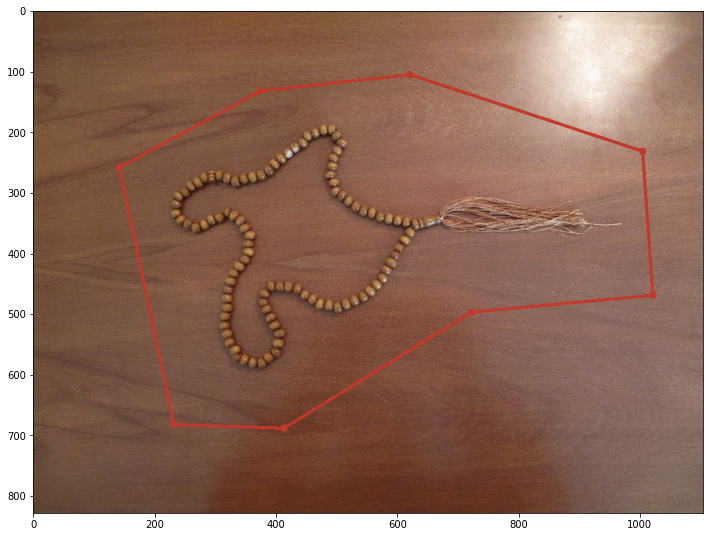

In [6]:
coords, new_img = get_points(main_img)

plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(new_img, cv.COLOR_BGR2RGB));

## Sample points from polygon

In [7]:
def distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

points = []
for p_idx in range(-1, len(coords)-1):
    x1, y1 = coords[p_idx]
    x2, y2 = coords[p_idx+1]
    line_points = np.stack((
        np.linspace(x1, x2, int(distance((x1, y1), (x2, y2)))).astype(np.int32),
        np.linspace(y1, y2, int(distance((x1, y1), (x2, y2)))).astype(np.int32)
    ), axis=1)
    for p in line_points:
        points.append(p)
        
points = np.array(points)
_, points_idx = np.unique(points, axis=0, return_index=True)
points = points[np.sort(points_idx)]

#### Visualization of points

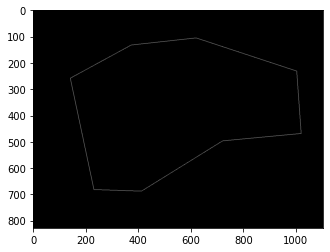

In [8]:
tmp = np.zeros_like(main_img)
tmp[points[:, 0], points[:, 1]] = 255

plt.imshow(tmp);

#### Visualization of sampled points on the original image

In [88]:
points.shape

(2362, 2)

(591, 2)


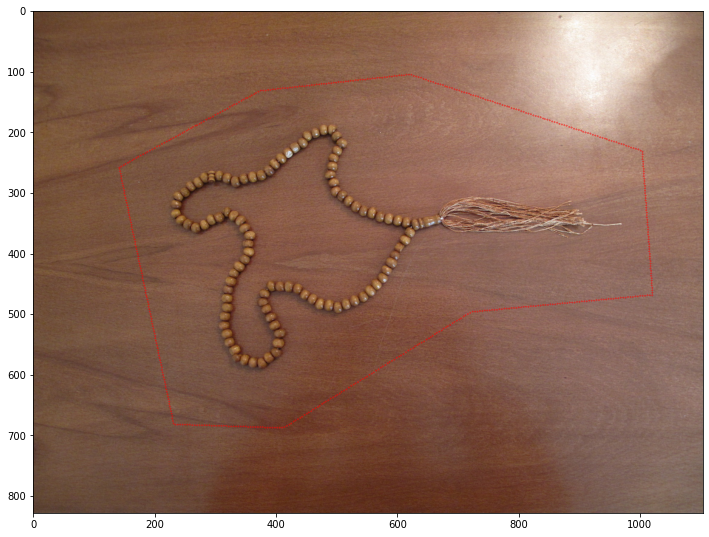

In [90]:
points2 = points[::4]
print(points2.shape)

tmp = main_img.copy()
for p in points2:
    cv.circle(tmp, tuple(p)[::-1], 1, (0, 0, 255), 1)

plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(tmp, cv.COLOR_BGR2RGB));

## Gradient of image

In [86]:
def normalize_image(arr):
    return (arr * 255 / np.max(arr)).astype(np.uint8)

def get_img_grad_single_channel(img):
    x_filter = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1],
    ])
    y_filter = x_filter.T
    
    result_x = signal.convolve2d(img, x_filter, mode='valid')
    result_y = signal.convolve2d(img, y_filter, mode='valid')
    edge_img = np.sqrt(result_x**2 + result_y**2)
    edge_img = edge_img * img.max() / edge_img.max()
    
    return edge_img


def get_img_grad(img):
    res = np.stack([get_img_grad_single_channel(img[:, :, i]) for i in range(3)], axis=-1)
    return normalize_image(res)

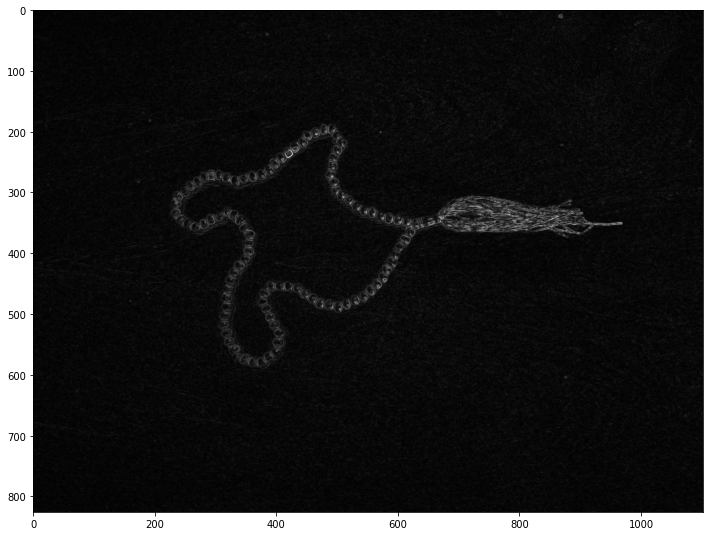

In [87]:
sobel_img = get_img_grad(main_img).mean(axis=2)
plt.figure(figsize=(12, 12))
plt.imshow(sobel_img, cmap='gray');

Not bad. But, we can make it better for further usage. In order to remove noise and detect edges better, We apply some blur filters. Then, using a threshold, we set pixels to `0` and `255`.

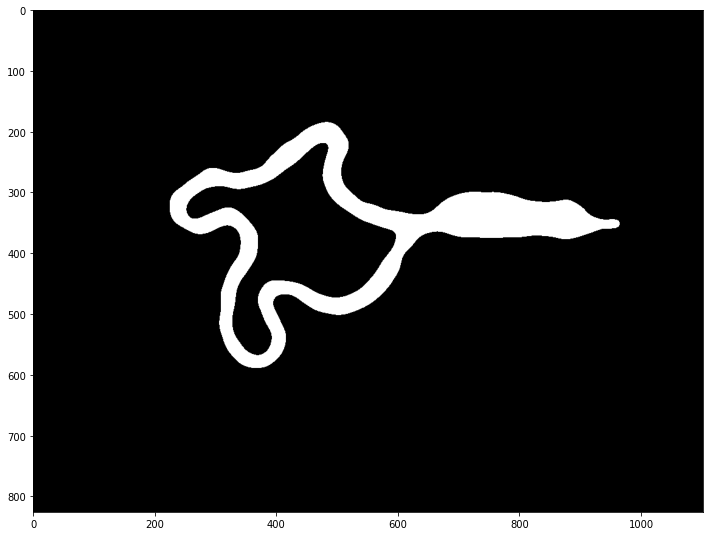

In [66]:
sobel_img2 = cv.GaussianBlur(sobel_img, (9, 9), 0)
for _ in range(5):
    sobel_img2 = cv.blur(sobel_img2, (15, 15))
sobel_img2[sobel_img2 < sobel_img2.max()/3.5] = 0
sobel_img2[sobel_img2 > 0] = 255

plt.figure(figsize=(12, 12))
plt.imshow(sobel_img2, cmap='gray');

Now we apply edge detection again. We do this because: after the points reach the outer boundry, they tend to move towards center. Since, in this area (till the inside boundry), the pixels have high value, they move toward the inside boundries. This is not based on our desire. So ...

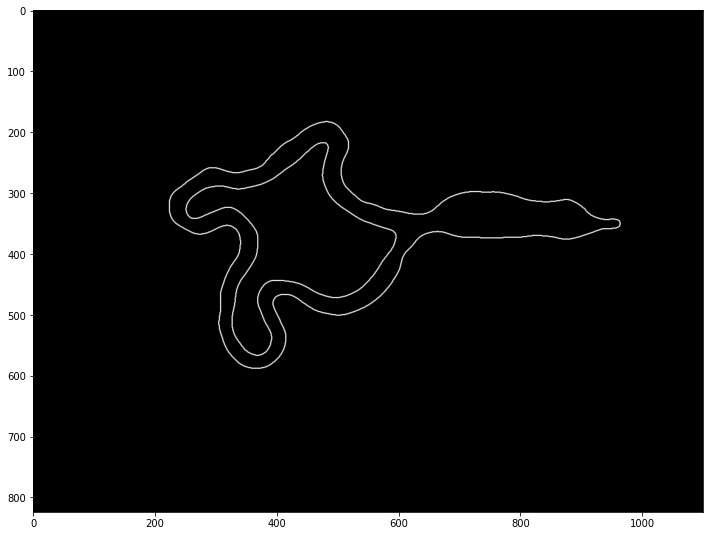

In [68]:
sobel_img = get_img_grad_single_channel(sobel_img2)
plt.figure(figsize=(12, 12))
plt.imshow(sobel_img, cmap='gray');

Perfect!

## Active Contour

This function outputs coordinates based on the `state_num` and `i` and `j`

In [69]:
def get_coords_based_on_state_num(i, j, state_num, length=3):
    assert length % 2 == 1

    r = (length-1)//2
    i_init, j_init = state_num//length, state_num%length
    
    return i_init+i-r, j_init+j-r

get_coords_based_on_state_num(23, 15, 6, 3) == (24, 14)

True

This will output the minimum cost path of dp

In [70]:
def get_dp_path(dp, directions, points_arr):
    result = []
    i = dp[:, -1].argmin()
    for j in range(directions.shape[1]-1, -1, -1):
        result.append(get_coords_based_on_state_num(points_arr[j][0], points_arr[j][1], i))
        i = directions[i, j]
    
    return np.array(result[::-1])

This function is responsible for outputing a point (based on two other points) which is pointing to inside of the polygon. 
We have chosen the points clockwise. So, given two points $p_1$ and $p_2$, if we rotate the vector $(p_1 - p_2)$ by $90$ degree, we get a vector pointing to the inside of the polygon. After normalizing and scaling and adding it to the center of $p_1$ and $p_2$, we get the desired point.

In [71]:
def get_point_between_pointing_to_inside(p1, p2):
    vec = p1 - p2
    rotated_vec = np.array([-vec[1], vec[0]])

    if np.linalg.norm(rotated_vec) == 0:
        return (p1+p2)/2

    result = (p1 + p2)/2 + (rotated_vec/np.linalg.norm(rotated_vec))*10
    
    return result

Below you can see the result after applying it to the sampled points of the polygon. You can see that all the red points are pointing to inside of the polygon.

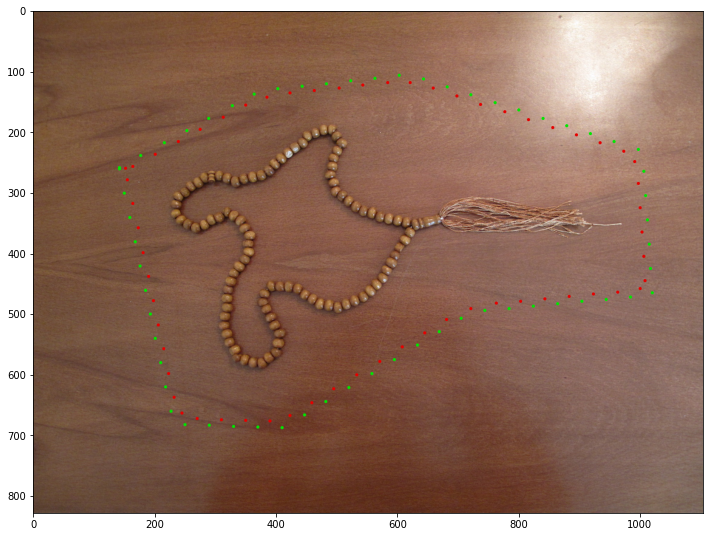

In [72]:
tmp = main_img.copy()
for p_idx in range(-1, points2[::10].shape[0]-1):
    p1, p2 = points2[::10][p_idx], points2[::10][p_idx+1]
    cv.circle(tmp, tuple(p1)[::-1], 1, (0, 230, 0), 2)
    cv.circle(tmp, tuple(get_point_between_pointing_to_inside(p1, p2).astype(np.int32))[::-1], 1, (0, 0, 230), 2)

plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(tmp, cv.COLOR_BGR2RGB));

This function connects points to achieve the contours

In [73]:
def draw_contours(img, points_arr):
    result = img.copy()
    for p_idx in range(-1, points_arr.shape[0]-1):
        cv.line(result, tuple(points_arr[p_idx])[::-1], tuple(points_arr[p_idx+1])[::-1], (0, 230, 0), 4)
    
    return result

This function checks whether two list of points are equal or not (the can have different permutations)

In [74]:
def are_point_lists_almost_equal(first_list, second_list, th=4):
    if first_list.shape != second_list.shape:
        return False
        
    ind_f = np.lexsort((first_list[:, 1], first_list[:, 0]))
    ind_s = np.lexsort((second_list[:, 1], second_list[:, 0]))
    
    return np.sum(np.linalg.norm(first_list[ind_f] - second_list[ind_s], axis=1)) < th

The main algorithm is implemented here.

Our total energy function contains 3 terms:
- Gradient: which is controlled by parameter `lamb`
- Distance between $v_i$ and $v_{i-1}$: which is controller by `alpha`
- Distance between $v_{i-1}$ and the point pointing to inside (from `get_point_between_pointing_to_inside`) which is added to total energy after iteration of 200. I used this term in order to move points further inside in some places where the concavity was high.

I set the `lamb` parameter to `100000` and the reason is to stop points from moving after the reach the boundries. I set `gamma` to `100` and `alpha` to `1` based on the aformentioned reason.

It's also worth mentioning that for implementation of viterbi DP formultation, I didn't fixed the last and the first column (to prevent the problem of seperating first and last points), Instead, I handled this problem in another way (which improved the speed of the implementation way better). I simply selected a random index from points list and divided this list to two parts and swapped the order. This trick changes the first and the last point on each iteration and prevents the above problem.


In [75]:
length = 3
num_states = length*length

lamb, alpha, gamma = 100000, 1, 100

points_arr = points2.copy()

extended_points2 = np.concatenate((points2, points2[0].reshape(1, 2)), axis=0)
d_bar = np.linalg.norm(points2 - extended_points2[1:], axis=1).mean()

images = []

for kk in tqdm(range(500)):
    dp = np.zeros((num_states, points_arr.shape[0]))
    directions = np.zeros((num_states, points_arr.shape[0]), dtype=np.int32)

    dp[:, 0] = [-lamb*sobel_img[p[0], p[1]] for p in [get_coords_based_on_state_num(points_arr[0][0], points_arr[0][1], k) for k in range(num_states)]]

    for j in range(1, dp.shape[1]):
        for i in range(num_states):
            prev_v_arr = np.array([get_coords_based_on_state_num(points_arr[j-1][0], points_arr[j-1][1], k) for k in range(num_states)])
            curr_v = np.array(get_coords_based_on_state_num(points_arr[j][0], points_arr[j][1], i))
            
            dists_arr = np.linalg.norm(prev_v_arr - curr_v, axis=1)
            grad = sobel_img[curr_v[0], curr_v[1]] 
            
            mid_point = get_point_between_pointing_to_inside(prev_v_arr[4], curr_v)
            mid_points_dist = np.linalg.norm(prev_v_arr - mid_point, axis=1)**2
            if kk < 200:
                mid_points_dist = 0 
            
            new_energy_arr = dp[:, j-1] - lamb*grad + alpha*(dists_arr**2 - d_bar) + gamma*mid_points_dist
            min_energy_idx = np.argmin(new_energy_arr)
            
            directions[i, j] = min_energy_idx
            dp[i, j] = new_energy_arr[min_energy_idx]
    
    prev_points_arr = points_arr
    points_arr = get_dp_path(dp, directions, points_arr)
    
    _, points_arr_idx = np.unique(points_arr, axis=0, return_index=True)
    points_arr = points_arr[np.sort(points_arr_idx)]
    
    rand_idx = np.random.randint(points_arr.shape[0])
    points_arr = np.concatenate((points_arr[rand_idx:], points_arr[:rand_idx]), axis=0)
    
    d_bar *= 0.98

    if kk % 10 == 0:
        images.append(draw_contours(main_img,  points_arr))
    
    if kk > 300 and are_point_lists_almost_equal(prev_points_arr, points_arr):
        print("Converged earlier!")
        break

 72%|███████▏  | 361/500 [01:10<00:27,  5.10it/s]

Converged earlier!


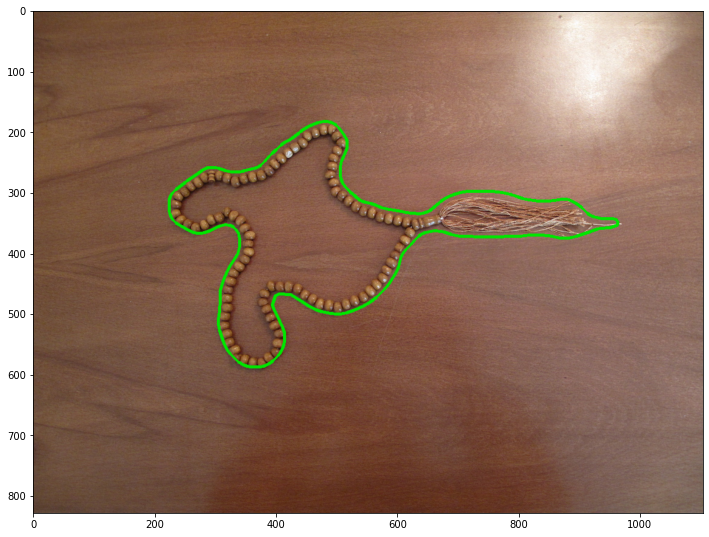

In [94]:
result = draw_contours(main_img,  points_arr)
    
plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB));

Perfect!

### Making video

In [81]:
len(images)

37

In [82]:
dir_name = "temp_video_images"
os.mkdir(dir_name)
for idx, image in enumerate(images):
    cv.imwrite(f"{dir_name}/{idx if idx > 9 else f'0{idx}'}.jpg", image)
(
    ffmpeg
    .input(f'{dir_name}/*.jpg', pattern_type='glob', framerate=4)
    .output('contour.mp4')
    .overwrite_output()
    .global_args('-loglevel', 'quiet')
    .run()
)
shutil.rmtree(dir_name)

In [83]:
from IPython.display import Video
Video("contour.mp4")